# CNN with non-softmax classification

## Backend and import

In [47]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [48]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pickle
import numpy as np

## Load Cifar10

In [49]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/cifar10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [50]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [51]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [52]:
y_traincl = keras.utils.to_categorical(y_train, num_classes)
y_testcl = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## VGG-like CNN

In [53]:
featureLayer1=[Conv2D(64, (3, 3), padding='same',input_shape=x_train.shape[1:]),
               Activation('relu'),
               Conv2D(64, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

featureLayer2=[Conv2D(128, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(128, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

featureLayer3=[Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

fullConnLayer=[Flatten(),
               Dense(1024),
               Activation('relu'),
               Dropout(0.5),
               Dense(1024),
               Activation('relu'),
               Dropout(0.5)]

classificationLayer=[Dense(num_classes),
                     Activation('softmax')]

model = Sequential(featureLayer1 + featureLayer2 + featureLayer3 + fullConnLayer + classificationLayer)

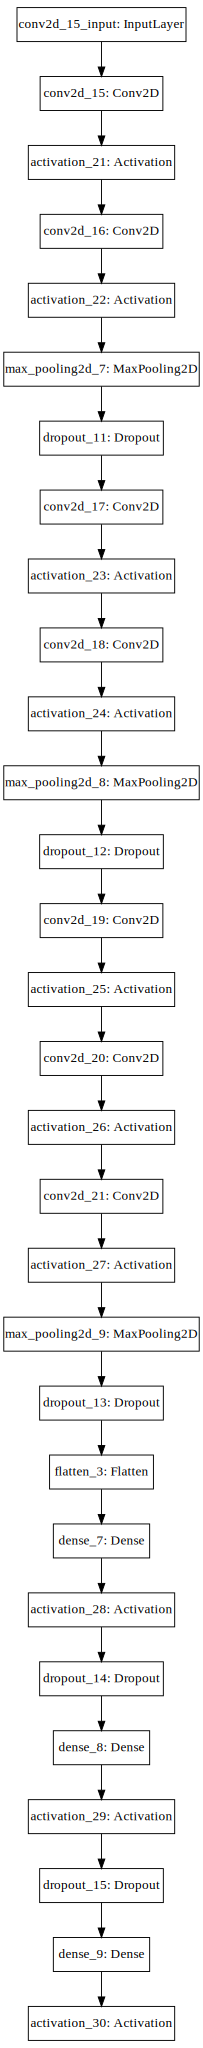

In [93]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file=os.path.join(saveDir, 'model.png'))
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Optimization and callbacks

In [55]:
opt = keras.optimizers.adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

## Load pre-trained weights

In [56]:
# Using pre-trained weights
model.load_weights(saveDir + "tensorflow_0.8224_model.hdf5")

## Train

In [ ]:
history = model.fit(x_train, y_traincl,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_testcl),
                    callbacks=[es_cb],
                    shuffle=True)

## Evaluation on Softmax

In [57]:
score = model.evaluate(x_test, y_testcl, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5586803967
Test accuracy: 0.8224


In [58]:
# reshape testing target to fit to scikit-learn metric form
y_testPred = model.predict(x_test)
y_testP = []
for x in y_testPred:
    y_testP.append(x.argmax())
y_testP = np.array(y_testP)

In [59]:
# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

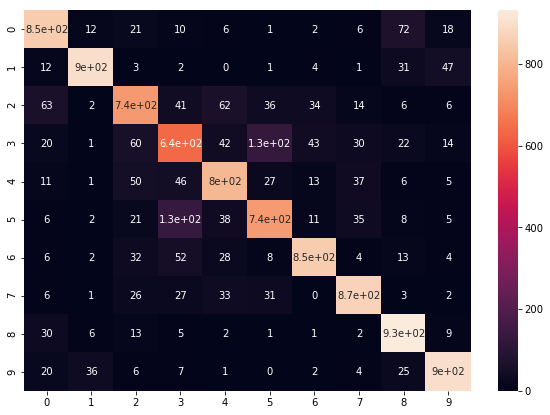

             precision    recall  f1-score   support

          0       0.83      0.85      0.84      1000
          1       0.93      0.90      0.92      1000
          2       0.76      0.74      0.75      1000
          3       0.66      0.64      0.65      1000
          4       0.79      0.80      0.80      1000
          5       0.76      0.74      0.75      1000
          6       0.89      0.85      0.87      1000
          7       0.87      0.87      0.87      1000
          8       0.83      0.93      0.88      1000
          9       0.89      0.90      0.89      1000

avg / total       0.82      0.82      0.82     10000

Accuracy: 0.8224


In [60]:
# get confusion matrix, classification report and accuracy score
from sklearn.metrics import classification_report, accuracy_score

print_cmx(y_test.T[0], y_testP)
print(classification_report(y_test.T[0], y_testP))
print("Accuracy: {0}".format(accuracy_score(y_test.T[0], y_testP)))

## Divide feature extraction layers and classification layers

In [61]:
# Layers definitions
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d780>
1 <keras.layers.core.Activation object at 0x7fbc0f92dc18>
2 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d0b8>
3 <keras.layers.core.Activation object at 0x7fbc0f92d710>
4 <keras.layers.pooling.MaxPooling2D object at 0x7fbc0f92d5c0>
5 <keras.layers.core.Dropout object at 0x7fbc0f92d400>
6 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d588>
7 <keras.layers.core.Activation object at 0x7fbc0f92d6d8>
8 <keras.layers.convolutional.Conv2D object at 0x7fbbdf94b470>
9 <keras.layers.core.Activation object at 0x7fbbdf94b860>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fbbd9f046d8>
11 <keras.layers.core.Dropout object at 0x7fbbd9f04630>
12 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d4e0>
13 <keras.layers.core.Activation object at 0x7fbc0f86cd68>
14 <keras.layers.convolutional.Conv2D object at 0x7fbc0f86ce48>
15 <keras.layers.core.Activation object at 0x7fbb58cccf98>
16 <keras.layers.convolutional.C

In [62]:
# feature extraction layer
getFeature = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[26].output])

In [63]:
# classification layer
getPrediction = K.function([model.layers[27].input, K.learning_phase()],
                           [model.layers[28].output])

## Get feature tensors for training and testing data

In [64]:
exTrain3000 = getFeature([x_train[:3000], 0])[0]

In [65]:
exTest1000 = getFeature([x_test[:1000], 0])[0]

In [66]:
# output of getFeature function
exTrain3000[0]

array([ 0.69946557,  0.18650442,  0.29139316, ...,  0.        ,
        0.        ,  0.31408471], dtype=float32)

## Reshape target to fit to scikit-learn

In [67]:
y_train3000 = y_train[:3000].reshape(y_train[:3000].shape[0],)
y_test1000 = y_test[:1000]

In [68]:
print(exTrain3000.shape, exTest1000.shape, y_train3000.shape, y_test1000.shape)

(3000, 1024) (1000, 1024) (3000,) (1000, 1)


## Grid search svm classification with feature extracted training data as input

In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
svmclf = clf.best_estimator_
svmclf.fit(exTrain3000, y_train3000)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

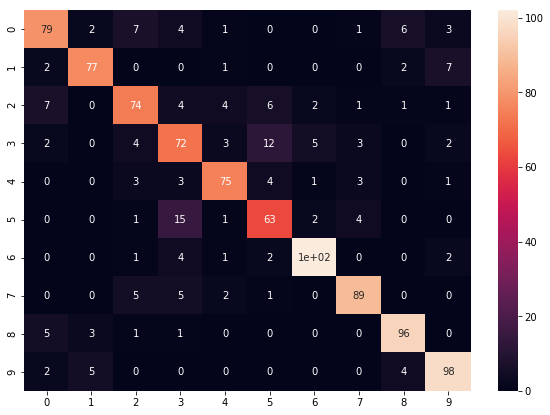

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       103
          1       0.89      0.87      0.88        89
          2       0.77      0.74      0.76       100
          3       0.67      0.70      0.68       103
          4       0.85      0.83      0.84        90
          5       0.72      0.73      0.72        86
          6       0.91      0.91      0.91       112
          7       0.88      0.87      0.88       102
          8       0.88      0.91      0.89       106
          9       0.86      0.90      0.88       109

avg / total       0.83      0.82      0.83      1000

Accuracy: 0.825


In [80]:
y_testSVM = svmclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testSVM)
print(classification_report(y_test1000, y_testSVM))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testSVM)))

## Grid search random forest classification with feature extracted training data as input

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1.0, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, None], 'n_estimators': [10, 20, 50], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [1.0, 3, 10], 'bootstrap': [True, False], 'max_features': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [91]:
rclf = rgclf.best_estimator_
rclf.fit(exTrain3000, y_train3000)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

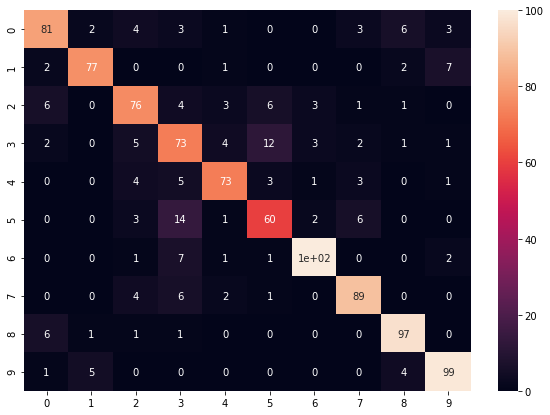

             precision    recall  f1-score   support

          0       0.83      0.79      0.81       103
          1       0.91      0.87      0.89        89
          2       0.78      0.76      0.77       100
          3       0.65      0.71      0.68       103
          4       0.85      0.81      0.83        90
          5       0.72      0.70      0.71        86
          6       0.92      0.89      0.90       112
          7       0.86      0.87      0.86       102
          8       0.87      0.92      0.89       106
          9       0.88      0.91      0.89       109

avg / total       0.83      0.82      0.83      1000

Accuracy: 0.825


In [92]:
y_testRF = rclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testRF)
print(classification_report(y_test1000, y_testRF))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testRF)))

## Grid search K nearest neighbors classification with feature extracted training data as input

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": [1, 5, 10, 30],
              "weights": ['uniform', 'distance'],
              "metric": ['minkowski','euclidean','manhattan'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'n_neighbors': [1, 5, 10, 30], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [88]:
kclf = kgclf.best_estimator_
kclf.fit(exTrain3000, y_train3000)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

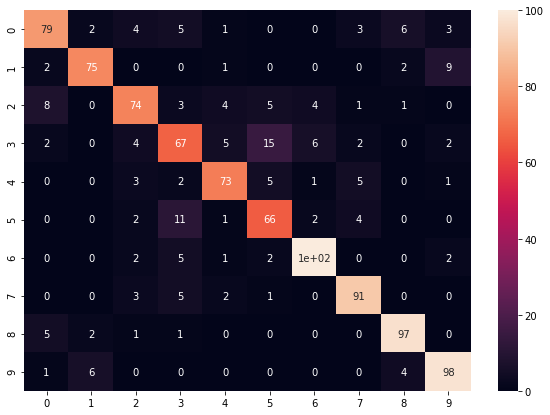

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       103
          1       0.88      0.84      0.86        89
          2       0.80      0.74      0.77       100
          3       0.68      0.65      0.66       103
          4       0.83      0.81      0.82        90
          5       0.70      0.77      0.73        86
          6       0.88      0.89      0.89       112
          7       0.86      0.89      0.88       102
          8       0.88      0.92      0.90       106
          9       0.85      0.90      0.88       109

avg / total       0.82      0.82      0.82      1000

Accuracy: 0.82


In [89]:
y_testKNN = kclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testKNN)
print(classification_report(y_test1000, y_testKNN))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testKNN)))